In [1]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
from pprint import pprint
from langchain_core.messages import HumanMessage, AIMessage

groq_api_key  = os.getenv("GROQ_API_KEY")

## langsmith Tracing
os.environ["LANGCHAIN_API_KEY"]= os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "Chatbot With Messages Summarization"

llm = ChatGroq(model_name="meta-llama/llama-4-scout-17b-16e-instruct", groq_api_key=groq_api_key)

In [4]:
from langgraph.graph import MessagesState

In [2]:
def add(a: int, b: int):
    """This is a function which can sum two integer number. first parameter is a, and second parameter is b. return also integer number"""
    
    return a + b


In [5]:
def llmInvoke(state: MessagesState):
    """This is a function which is responsible for generate response based on user query."""
    
    llm_with_tool = llm.bind_tools([add])
    response = llm_with_tool.invoke(state['messages'])
    
    return {
        'messages': response
    }

## build the graph

In [7]:
tools = [add]

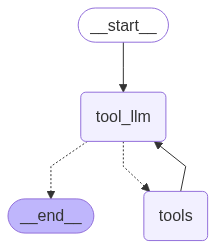

In [22]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(MessagesState)
builder.add_node('tool_llm', llmInvoke)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_llm")
builder.add_conditional_edges(
    "tool_llm",
    # if the latest messages (result) form the tool_llm is a tool call --> tools_condition routes to the tools
    # if the latest messages (result) form the tool_llm is not a tool call --> tools_condition routs to END
    tools_condition
)
builder.add_edge('tools', 'tool_llm')

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

## display
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
config = {"configurable": {"thread_id": "1"}}

response = graph.invoke(
    {
        'messages': "Can you add this two number 5 and 7."
    },
    config=config
)

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Can you add this two number 5 and 7.
================================== Ai Message ==================================
Tool Calls:
  add (call_fqvt)
 Call ID: call_fqvt
  Args:
    a: 5
    b: 7
================================= Tool Message =================================
Name: add

12
================================== Ai Message ==================================
Tool Calls:
  add (call_0ekd)
 Call ID: call_0ekd
  Args:
    a: 5
    b: 7
================================= Tool Message =================================
Name: add

12
================================== Ai Message ==================================

That's correct! The result of adding 5 and 7 is indeed 12. 

If you have any more numbers you'd like to add, feel free to let me know!
